In [11]:
import numpy as np
import pandas as pd

# Constants
time_end = 24 * 60  
service_rate = 2 
np.random.seed(45)  

# Intensity function λ(t) for non-homogeneous Poisson arrivals
intensity_function = lambda t: 0.5 * np.sin((2 * np.pi * t / 1440) - (np.pi / 2)) + 1


time_array = np.arange(0, time_end, 0.1)


cumulative_intensity = np.cumsum(intensity_function(time_array)) * 0.1  
total_events = int(cumulative_intensity[-1])  


uniform_randoms = np.sort(np.random.uniform(0, cumulative_intensity[-1], total_events))
arrival_times = np.interp(uniform_randoms, cumulative_intensity, time_array)


service_times = np.random.exponential(1/service_rate, total_events)


service_start_times = [arrival_times[0]]  
service_end_times = [service_start_times[0] + service_times[0]]

for i in range(1, total_events):
    service_start = max(service_end_times[i-1], arrival_times[i])
    service_end = service_start + service_times[i]
    service_start_times.append(service_start)
    service_end_times.append(service_end)

# Creating the dataset
df = pd.DataFrame({
    'Arrival Time': arrival_times,
    'Service Start Time': service_start_times,
    'Service End Time': service_end_times
})

print(df)


      Arrival Time  Service Start Time  Service End Time
0         1.677171            1.677171          2.165763
1        12.302485           12.302485         13.468223
2        21.566641           21.566641         21.752077
3        21.715788           21.752077         22.665187
4        24.153873           24.153873         24.662811
...            ...                 ...               ...
1434   1427.078206         1427.078206       1427.111903
1435   1427.383098         1427.383098       1427.423196
1436   1432.692364         1432.692364       1432.698682
1437   1435.316016         1435.316016       1437.662424
1438   1437.005455         1437.662424       1437.808035

[1439 rows x 3 columns]


In [13]:
import pandas as pd


def convert_time(time_in_minutes):
    
    time_in_minutes = max(time_in_minutes, 0)
   
    total_seconds = int(time_in_minutes * 60)
    
    hours = total_seconds // 3600
    minutes = (total_seconds % 3600) // 60
    seconds = total_seconds % 60
  
    return f"{hours:02}:{minutes:02}:{seconds:02}"

In [15]:
df['Arrival Time'] = df['Arrival Time'].apply(convert_time)
df['Service Start Time'] = df['Service Start Time'].apply(convert_time)
df['Service End Time'] = df['Service End Time'].apply(convert_time)

# Display the updated DataFrame
print(df)

     Arrival Time Service Start Time Service End Time
0        00:01:40           00:01:40         00:02:09
1        00:12:18           00:12:18         00:13:28
2        00:21:33           00:21:33         00:21:45
3        00:21:42           00:21:45         00:22:39
4        00:24:09           00:24:09         00:24:39
...           ...                ...              ...
1434     23:47:04           23:47:04         23:47:06
1435     23:47:22           23:47:22         23:47:25
1436     23:52:41           23:52:41         23:52:41
1437     23:55:18           23:55:18         23:57:39
1438     23:57:00           23:57:39         23:57:48

[1439 rows x 3 columns]


In [17]:
df.to_csv('periodicnew1.csv', index=False)

In [19]:
df1=df.copy()

In [21]:
df1.head()

,Arrival Time,Service Start Time,Service End Time
0,00:01:40,00:01:40,00:02:09
1,00:12:18,00:12:18,00:13:28
2,00:21:33,00:21:33,00:21:45
3,00:21:42,00:21:45,00:22:39
4,00:24:09,00:24:09,00:24:39


In [23]:
df1['Waiting Time (seconds)'] = (pd.to_datetime(df1['Service Start Time'].astype(str)) - 
                                             pd.to_datetime(df1['Arrival Time'].astype(str))).dt.total_seconds()


In [25]:
df1['Service Time (seconds)'] = (pd.to_datetime(df1['Service End Time'].astype(str)) - 
                                             pd.to_datetime(df1['Service Start Time'].astype(str))).dt.total_seconds()

df1

,Arrival Time,Service Start Time,Service End Time,Waiting Time (seconds),Service Time (seconds)
0,00:01:40,00:01:40,00:02:09,0.0,29.0
1,00:12:18,00:12:18,00:13:28,0.0,70.0
2,00:21:33,00:21:33,00:21:45,0.0,12.0
3,00:21:42,00:21:45,00:22:39,3.0,54.0
4,00:24:09,00:24:09,00:24:39,0.0,30.0
...,...,...,...,...,...
1434,23:47:04,23:47:04,23:47:06,0.0,2.0
1435,23:47:22,23:47:22,23:47:25,0.0,3.0
1436,23:52:41,23:52:41,23:52:41,0.0,0.0
1437,23:55:18,23:55:18,23:57:39,0.0,141.0


In [33]:
# Combine arrival and service end times into one DataFrame for processing.
# Here, 'Type' distinguishes between an arrival and a service completion (departure).
events = (
    df1[['Arrival Time']].assign(Type='Arrival')
    .append(df1[['Service End Time']].rename(columns={'Service End Time': 'Arrival Time'}).assign(Type='Departure'))
    .sort_values(by='Arrival Time').reset_index(drop=True)
)

# Initialize the number of customers in the system and a list to keep track of this count at each arrival.
num_customers_in_system = 0
customers_at_arrival = []

# Process each event in order.
for _, event in events.iterrows():
    if event['Type'] == 'Arrival':
        # For an arrival, record the current number of customers, then increment the count.
        customers_at_arrival.append(num_customers_in_system)
        num_customers_in_system += 1
    else:
        # For a departure, just decrement the count.
        num_customers_in_system -= 1

# Assign the recorded number of customers at each arrival to the original simulation data.
df1['Customers in System'] = customers_at_arrival

C:\Users\ajayd\AppData\Local\Temp\ipykernel_16736\2667816766.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  .append(df1[['Service End Time']].rename(columns={'Service End Time': 'Arrival Time'}).assign(Type='Departure'))


In [35]:
df1

,Arrival Time,Service Start Time,Service End Time,Waiting Time (seconds),Service Time (seconds),Customers in System
0,00:01:40,00:01:40,00:02:09,0.0,29.0,0
1,00:12:18,00:12:18,00:13:28,0.0,70.0,0
2,00:21:33,00:21:33,00:21:45,0.0,12.0,0
3,00:21:42,00:21:45,00:22:39,3.0,54.0,1
4,00:24:09,00:24:09,00:24:39,0.0,30.0,0
...,...,...,...,...,...,...
1434,23:47:04,23:47:04,23:47:06,0.0,2.0,0
1435,23:47:22,23:47:22,23:47:25,0.0,3.0,0
1436,23:52:41,23:52:41,23:52:41,0.0,0.0,0
1437,23:55:18,23:55:18,23:57:39,0.0,141.0,0


In [37]:
df1.to_csv('periodicnew2.csv', index=False)

In [39]:
df1=pd.read_csv("D:/New folder/Queueing/new/Simulation/latest/periodicnew2 - Copy.csv")
df1

,Arrival Time,Service Start Time,Service End Time,Waiting Time (seconds),Service Time (seconds),Customers in System,Arrival Time(m)
0,00:01:40,00:01:40,00:02:09,0,29,0,1.677171
1,00:12:18,00:12:18,00:13:28,0,70,0,12.302485
2,00:21:33,00:21:33,00:21:45,0,12,0,21.566641
3,00:21:42,00:21:45,00:22:39,3,54,1,21.715788
4,00:24:09,00:24:09,00:24:39,0,30,0,24.153873
...,...,...,...,...,...,...,...
1428,23:47:04,23:47:04,23:47:06,0,2,0,1427.078206
1429,23:47:22,23:47:22,23:47:25,0,3,0,1427.383098
1430,23:52:41,23:52:41,23:52:41,0,0,0,1432.692364
1431,23:55:18,23:55:18,23:57:39,0,141,0,1435.316016


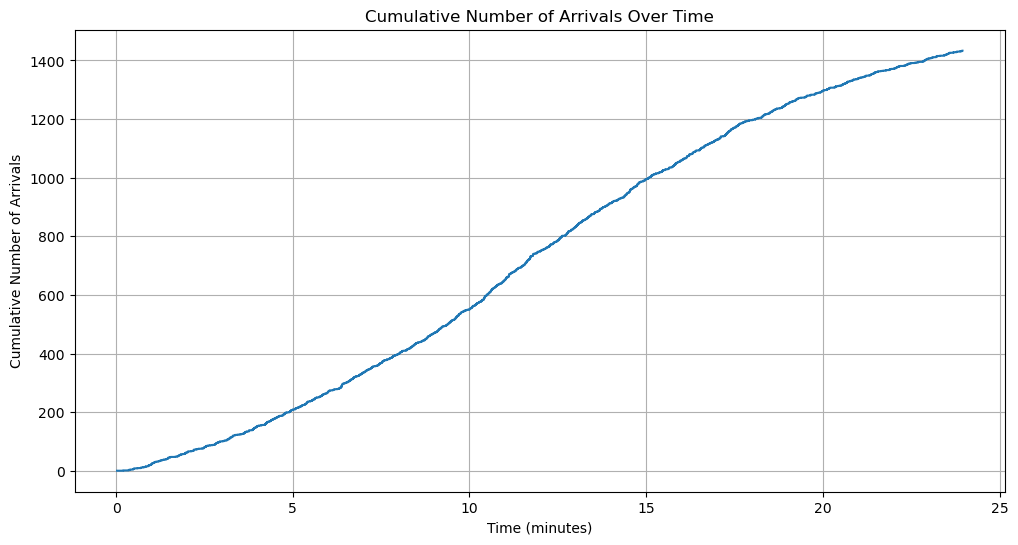

In [41]:
import matplotlib.pyplot as plt

df1 = df1.sort_values('Arrival Time(m)')

# Calculate the cumulative number of arrivals
df1['Cumulative Arrivals'] = np.arange(1, len(df1) + 1)


plt.figure(figsize=[12, 6])
plt.step(df1['Arrival Time(m)'] / 60, df1['Cumulative Arrivals'], where='post')  # Convert seconds to minutes for x-axis
plt.title('Cumulative Number of Arrivals Over Time')
plt.xlabel('Time (minutes)')
plt.ylabel('Cumulative Number of Arrivals')
plt.grid(True) 
plt.show()  

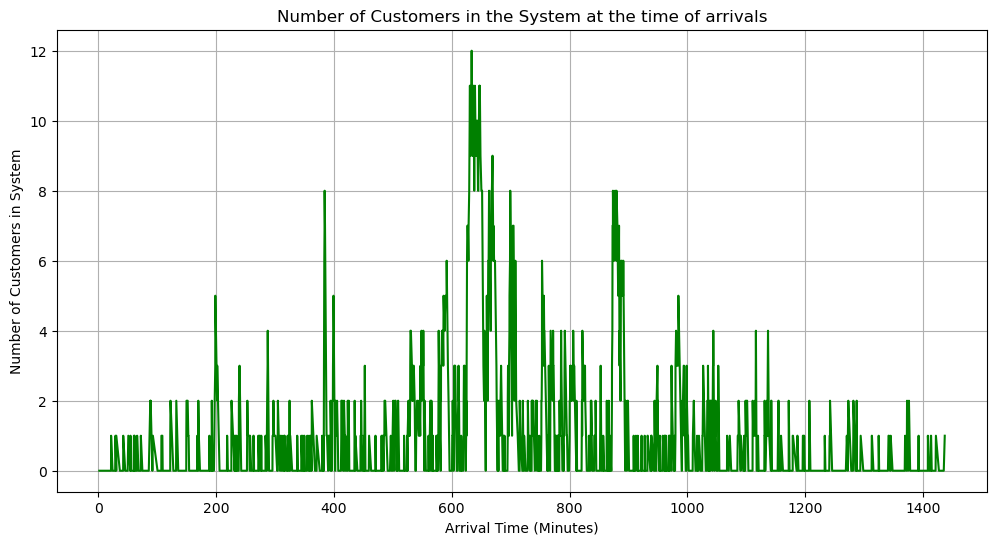

In [43]:
df1.sort_values('Arrival Time(m)', inplace=True)

plt.figure(figsize=[12, 6])
plt.plot(df1['Arrival Time(m)'], df1['Customers in System'],color='g')
plt.title('Number of Customers in the System at the time of arrivals')
plt.xlabel('Arrival Time (Minutes)')
plt.ylabel('Number of Customers in System')
plt.grid(True)

plt.savefig('number.png')
plt.show()

In [45]:
df1['Sojourn Time (seconds)']=df1['Waiting Time (seconds)']+df1['Service Time (seconds)']
df1

,Arrival Time,Service Start Time,Service End Time,Waiting Time (seconds),Service Time (seconds),Customers in System,Arrival Time(m),Cumulative Arrivals,Sojourn Time (seconds)
0,00:01:40,00:01:40,00:02:09,0,29,0,1.677171,1,29
1,00:12:18,00:12:18,00:13:28,0,70,0,12.302485,2,70
2,00:21:33,00:21:33,00:21:45,0,12,0,21.566641,3,12
3,00:21:42,00:21:45,00:22:39,3,54,1,21.715788,4,57
4,00:24:09,00:24:09,00:24:39,0,30,0,24.153873,5,30
...,...,...,...,...,...,...,...,...,...
1428,23:47:04,23:47:04,23:47:06,0,2,0,1427.078206,1429,2
1429,23:47:22,23:47:22,23:47:25,0,3,0,1427.383098,1430,3
1430,23:52:41,23:52:41,23:52:41,0,0,0,1432.692364,1431,0
1431,23:55:18,23:55:18,23:57:39,0,141,0,1435.316016,1432,141


In [47]:
import pandas as pd


df1['Hour'] = pd.to_datetime(df1['Arrival Time'], format='%H:%M:%S').dt.hour



In [49]:
df1

,Arrival Time,Service Start Time,Service End Time,Waiting Time (seconds),Service Time (seconds),Customers in System,Arrival Time(m),Cumulative Arrivals,Sojourn Time (seconds),Hour
0,00:01:40,00:01:40,00:02:09,0,29,0,1.677171,1,29,0
1,00:12:18,00:12:18,00:13:28,0,70,0,12.302485,2,70,0
2,00:21:33,00:21:33,00:21:45,0,12,0,21.566641,3,12,0
3,00:21:42,00:21:45,00:22:39,3,54,1,21.715788,4,57,0
4,00:24:09,00:24:09,00:24:39,0,30,0,24.153873,5,30,0
...,...,...,...,...,...,...,...,...,...,...
1428,23:47:04,23:47:04,23:47:06,0,2,0,1427.078206,1429,2,23
1429,23:47:22,23:47:22,23:47:25,0,3,0,1427.383098,1430,3,23
1430,23:52:41,23:52:41,23:52:41,0,0,0,1432.692364,1431,0,23
1431,23:55:18,23:55:18,23:57:39,0,141,0,1435.316016,1432,141,23


In [51]:
hour_counts = df1['Hour'].value_counts().sort_index()
print(hour_counts)

0      23
1      40
2      38
3      52
4      56
5      61
6      66
7      63
8      72
9      80
10    100
11     98
12     83
13     81
14     82
15     64
16     71
17     66
18     56
19     44
20     43
21     32
22     36
23     26
Name: Hour, dtype: int64


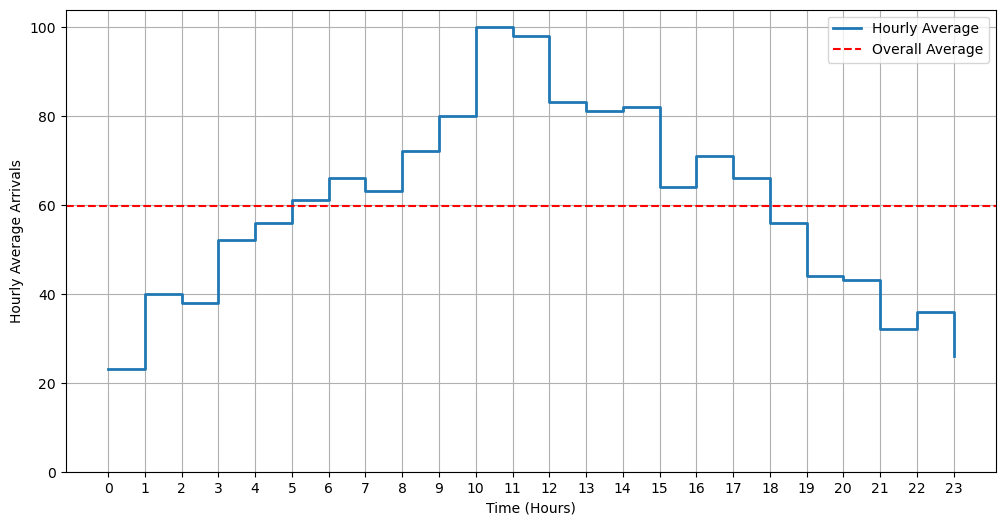

In [53]:

hours = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10,11,12,13,14,15,16,17,18,19,20,21,22,23]  # Continue as needed
values = [23, 40, 38,52,56,61,66,63,72,80,100,98,83,81,82,64,71,66,56,44,43,32,36,26]  # Continue as needed, match length with 'hours'


plt.figure(figsize=[12, 6])
plt.step(hours, values, where='post', linestyle='-',linewidth=2, label="Hourly Average")
plt.axhline(y=59.70, color='r', linestyle='--',label="Overall Average")
plt.title('')
plt.xlabel('Time (Hours)')
plt.ylabel('Hourly Average Arrivals')
plt.grid(True)
plt.xticks(range(min(hours), max(hours)+1))  
plt.ylim(bottom=0)  
plt.legend()

plt.savefig('average arrivals.png')
plt.show()

In [55]:
sum(hour_counts)

1433

In [57]:
# Calculate the average sojourn time for each hour
average_sojourn_by_hour = df1.groupby('Hour')['Sojourn Time (seconds)'].mean().reset_index(name='Average Sojourn Time (seconds)')

df1 = pd.merge(df1, average_sojourn_by_hour, on='Hour', how='left')


In [59]:
df1

,Arrival Time,Service Start Time,Service End Time,Waiting Time (seconds),Service Time (seconds),Customers in System,Arrival Time(m),Cumulative Arrivals,Sojourn Time (seconds),Hour,Average Sojourn Time (seconds)
0,00:01:40,00:01:40,00:02:09,0,29,0,1.677171,1,29,0,45.391304
1,00:12:18,00:12:18,00:13:28,0,70,0,12.302485,2,70,0,45.391304
2,00:21:33,00:21:33,00:21:45,0,12,0,21.566641,3,12,0,45.391304
3,00:21:42,00:21:45,00:22:39,3,54,1,21.715788,4,57,0,45.391304
4,00:24:09,00:24:09,00:24:39,0,30,0,24.153873,5,30,0,45.391304
...,...,...,...,...,...,...,...,...,...,...,...
1428,23:47:04,23:47:04,23:47:06,0,2,0,1427.078206,1429,2,23,24.230769
1429,23:47:22,23:47:22,23:47:25,0,3,0,1427.383098,1430,3,23,24.230769
1430,23:52:41,23:52:41,23:52:41,0,0,0,1432.692364,1431,0,23,24.230769
1431,23:55:18,23:55:18,23:57:39,0,141,0,1435.316016,1432,141,23,24.230769


In [61]:
# Calculate the average sojourn time for each hour
average_service_by_hour = df1.groupby('Hour')['Service Time (seconds)'].mean().reset_index(name='Average Service Time (seconds)')


df1 = pd.merge(df1, average_service_by_hour, on='Hour', how='left')

In [63]:
# Calculate the average sojourn time for each hour
average_waiting_by_hour = df1.groupby('Hour')['Waiting Time (seconds)'].mean().reset_index(name='Average Waiting Time (seconds)')


df1 = pd.merge(df1, average_waiting_by_hour, on='Hour', how='left')

In [65]:
df1

,Arrival Time,Service Start Time,Service End Time,Waiting Time (seconds),Service Time (seconds),Customers in System,Arrival Time(m),Cumulative Arrivals,Sojourn Time (seconds),Hour,Average Sojourn Time (seconds),Average Service Time (seconds),Average Waiting Time (seconds)
0,00:01:40,00:01:40,00:02:09,0,29,0,1.677171,1,29,0,45.391304,36.826087,8.565217
1,00:12:18,00:12:18,00:13:28,0,70,0,12.302485,2,70,0,45.391304,36.826087,8.565217
2,00:21:33,00:21:33,00:21:45,0,12,0,21.566641,3,12,0,45.391304,36.826087,8.565217
3,00:21:42,00:21:45,00:22:39,3,54,1,21.715788,4,57,0,45.391304,36.826087,8.565217
4,00:24:09,00:24:09,00:24:39,0,30,0,24.153873,5,30,0,45.391304,36.826087,8.565217
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1428,23:47:04,23:47:04,23:47:06,0,2,0,1427.078206,1429,2,23,24.230769,21.076923,3.153846
1429,23:47:22,23:47:22,23:47:25,0,3,0,1427.383098,1430,3,23,24.230769,21.076923,3.153846
1430,23:52:41,23:52:41,23:52:41,0,0,0,1432.692364,1431,0,23,24.230769,21.076923,3.153846
1431,23:55:18,23:55:18,23:57:39,0,141,0,1435.316016,1432,141,23,24.230769,21.076923,3.153846


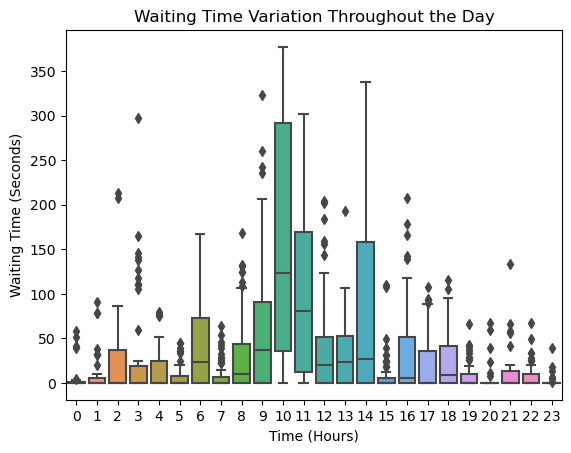

In [73]:
import seaborn as sns

sns.boxplot(x=df1['Hour'], y=df1['Waiting Time (seconds)'])
plt.title('Waiting Time Variation Throughout the Day')
plt.xlabel('Time (Hours)')
plt.ylabel('Waiting Time (Seconds)')

plt.savefig('boxplot(waiting).png')
plt.show()

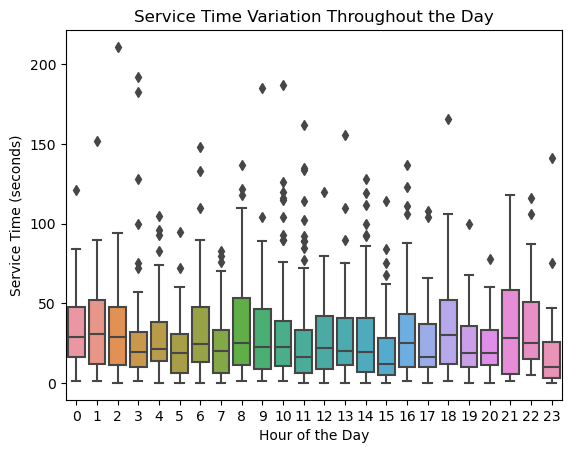

In [69]:

sns.boxplot(x=df1['Hour'], y=df1['Service Time (seconds)'])
plt.title('Service Time Variation Throughout the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Service Time (seconds)')
plt.show()

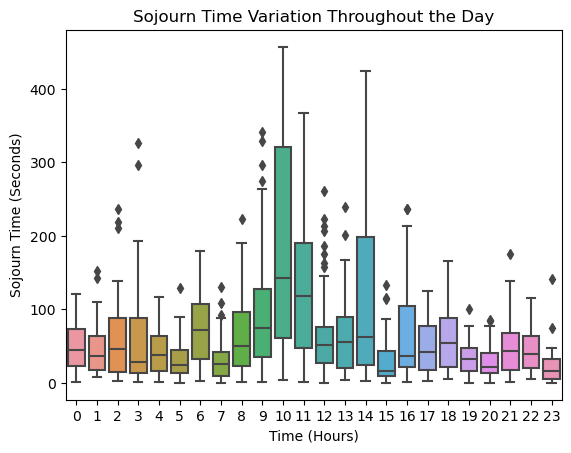

In [75]:

sns.boxplot(x=df1['Hour'], y=df1['Sojourn Time (seconds)'])
plt.title('Sojourn Time Variation Throughout the Day')
plt.xlabel('Time (Hours)')
plt.ylabel('Sojourn Time (Seconds)')

plt.savefig('boxplot(sojourn).png')

plt.show()

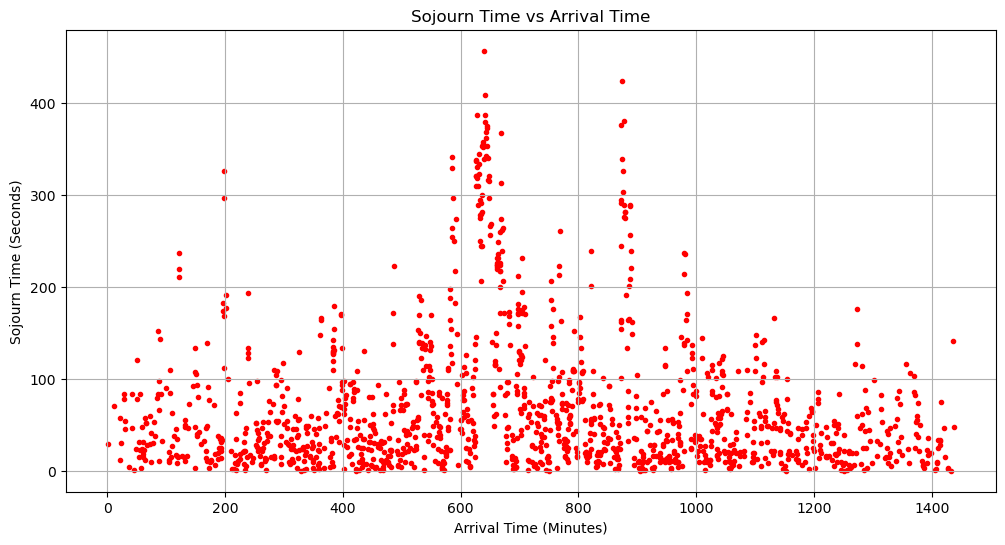

In [79]:

plt.figure(figsize=[12, 6])
plt.scatter(df1['Arrival Time(m)'], df1['Sojourn Time (seconds)'],marker=".",c="red")
plt.title('Sojourn Time vs Arrival Time')
plt.xlabel('Arrival Time (Minutes)')
plt.ylabel('Sojourn Time (Seconds)')
plt.grid(True)

plt.savefig('sojourn scatter.png')

plt.show()

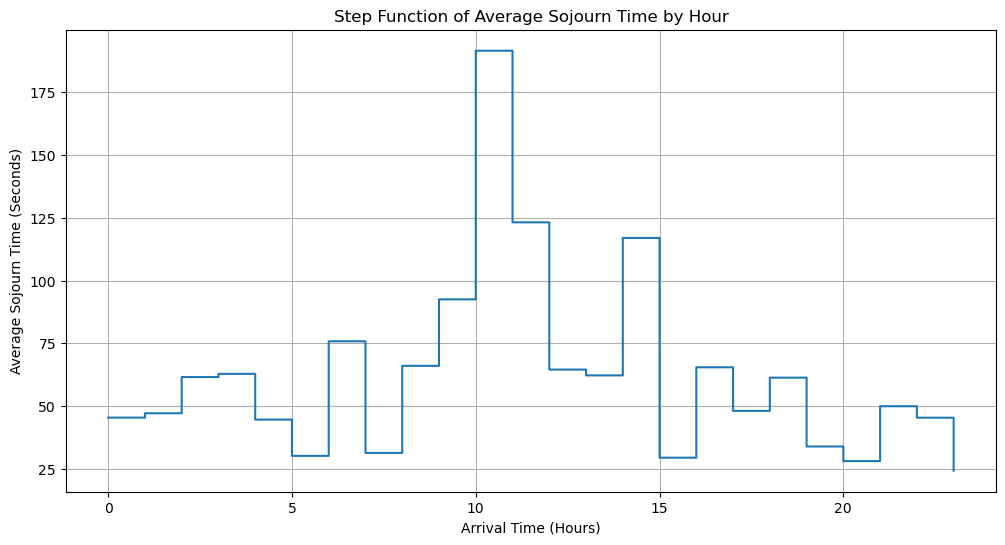

In [81]:
plt.figure(figsize=[12, 6])
plt.step(df1['Hour'], df1['Average Sojourn Time (seconds)'], where='post')
plt.title('Step Function of Average Sojourn Time by Hour')
plt.xlabel('Arrival Time (Hours)')
plt.ylabel('Average Sojourn Time (Seconds)')
plt.grid(True)
plt.savefig('step sojourn.png')

plt.show()

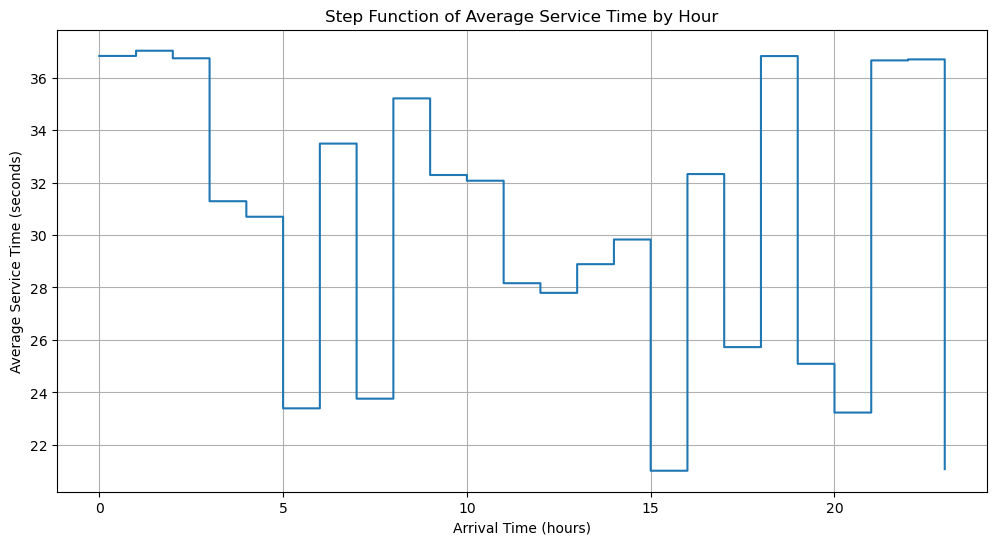

In [83]:
plt.figure(figsize=[12, 6])
plt.step(df1['Hour'], df1['Average Service Time (seconds)'], where='post')
plt.title('Step Function of Average Service Time by Hour')
plt.xlabel('Arrival Time (hours)')
plt.ylabel('Average Service Time (seconds)')
plt.grid(True)

plt.savefig('sojourn scatter.png')
plt.show()

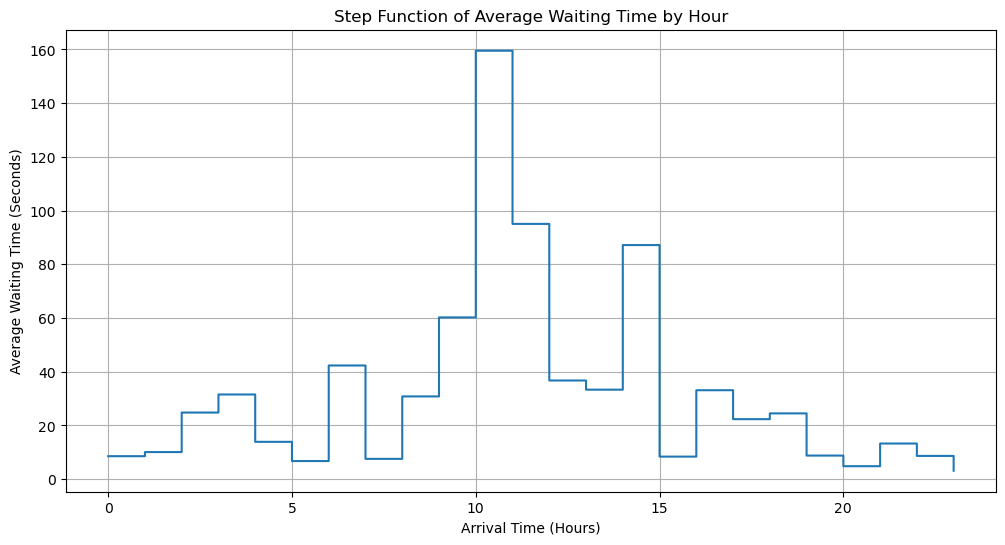

In [85]:
plt.figure(figsize=[12, 6])
plt.step(df1['Hour'], df1['Average Waiting Time (seconds)'], where='post')
plt.title('Step Function of Average Waiting Time by Hour')
plt.xlabel('Arrival Time (Hours)')
plt.ylabel('Average Waiting Time (Seconds)')
plt.grid(True)


plt.savefig('step waiting.png')

plt.show()